In [2]:
%load_ext autoreload

%autoreload 2

In [55]:
import os
import numpy as np
from matplotlib import pyplot as plt
import torch
from celluloid import Camera
from matplotlib.backend_bases import FigureCanvasBase
from matplotlib.animation import FuncAnimation
from IPython.display import clear_output
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import timeit

from src.environment_old import LogEnv_old
from src.utils import path_distance_new, check_missing_vertexes_jampr

from src.or_functions import compute_distance

#from src.environment import LogEnv
#from src.train import train
#from src.architecture import AttentionModel
#from src.evaluation import compute_mean_metric, compute_data_metric, compute_mean_metric_with_or
#from src.vizualisation import demonstration, action_animation
from src.environment_jampr_real import LogEnv
from src.architecture_jampr_2 import AttentionModel
from src.train_jampr import train
from src.or_functions_jampr import compute_distance
from src.evaluation_jampr import compute_mean_metric, compute_mean_metric_with_or, compute_metric_on_data
from src.vizualisation_jampr import demonstration, env_plot

import GPUtil
from pytorch_memlab import LineProfiler, MemReporter

## Отладка

In [19]:
env = LogEnv(n=20, batch_size=1, active_num=1, K=5)
env.reset()
'a'

'a'

In [ ]:
model = AttentionModel(active_num=1).to('cuda')
#model.eval()
'a'
#model.load_state_dict(weights)

In [ ]:
features, _, mask = env.reset(full_reset=False)
print(mask)
print(features[0][:, :, 3:5])
print(features[0][:, :, 2])
flag = False
while not flag:
    v1 = int(input())
    v2 = int(input())
    v = torch.tensor([v1, v2]).view(1, -1)
    v1 = int(input())
    v2 = int(input())
    v_m = torch.tensor([v1, v2]).view(1, -1)
    v = torch.cat([v, v_m], dim=0)
    print(v)
    #print(d[0, v[0, 1], :])
    features, mask, flag = env.step(v)
    features = list(map(lambda x: x.to('cuda'), features))
    print(mask)
    print(flag)
print(env.tour_plan)
print(features[2][:, :, 4].sum().to('cpu') + check_missing_vertexes_jampr(env.tour_plan, problem_size) * 10000)

#20 -> 13 -> 2 -> 16 -> 18 -> 15 -> 14 -> 3
#9 -> 1 -> 17 -> 10 -> 7 -> 8
#19 -> 12 -> 5 -> 11 -> 6 -> 4


#17 -> 9 -> 7 -> 1 -> 19 -> 12 -> 11 -> 6
#13 -> 3
#2 -> 15
#20 -> 5 -> 4 -> 14
#10 -> 8 -> 16 -> 18

In [21]:
features, _, mask = env.reset(full_reset=True)

In [22]:
# print(mask)
features, _, mask = env.reset(full_reset=False)
print(features[0][:, :, 3:5])
print(features[0][:, :, 2])
flag = False
while not flag:
    v1 = int(input())
    v2 = int(input())
    v = torch.tensor([v1, v2]).view(1, -1)
    print(v)
    #print(d[0, v[0, 1], :])
    features_new, mask, flag = env.step(v)
    features_new = list(map(lambda x: x.to('cuda'), features_new))
    print(features_new[1][:, :, -1])
    print(mask)
    print(flag)
print(env.tour_plan)
print(env.vehicle[:, :, 4].sum().to('cpu') + check_missing_vertexes_jampr(env.tour_plan, 20))

#4 -> 3 -> 14 -> 17 -> 7 -> 16 -> 21
#8 -> 20 -> 1 -> 12 -> 2 -> 11-> 21 
#5 -> 13 -> 21
#9 -> 10 -> 15 -> 6 -> 19 -> 18 -> 21

tensor([[[0.0000, 0.2083],
         [0.6833, 0.8500],
         [0.6950, 0.8617],
         [0.8324, 0.9991],
         [0.3360, 0.5026],
         [0.0364, 0.2031],
         [0.9879, 1.0000],
         [0.6764, 0.8431],
         [0.9924, 1.0000],
         [0.2709, 0.4375],
         [0.0285, 0.1952],
         [0.1813, 0.3480],
         [0.9807, 1.0000],
         [0.6374, 0.8040],
         [0.0690, 0.2357],
         [0.6442, 0.8109],
         [0.2439, 0.4106],
         [0.3248, 0.4915],
         [0.8320, 0.9987],
         [0.8878, 1.0000],
         [0.2663, 0.4329],
         [0.0000, 1.0000]]])
tensor([[0.0000, 0.0871, 0.0629, 0.0243, 0.0043, 0.0414, 0.0043, 0.0014, 0.0871,
         0.1129, 0.0286, 0.0486, 0.1057, 0.0657, 0.0157, 0.1271, 0.0871, 0.0529,
         0.0471, 0.0643, 0.0029, 0.0000]])
0


KeyboardInterrupt: 

In [25]:
device = 'cuda'

In [ ]:
problem_size = 50

In [112]:
#env = LogEnv(n=10, batch_size=1, active_num=1)
features, d, mask = env.reset(full_reset=True)
print(d)
#print(mask)
#print(env.pairs)
print(features[0][:, :, 3:5])
print(features[0][:, :, 2])
flag = False
t = 0
precomputed = None
features[0] = features[0].to(device)
features[1] = features[1].to(device)
flag_done = False
t = 0
precomputed = None
while not flag_done:
    v, _, precomputed = model(features, mask, t, precomputed, False)
    v = v.to('cpu')
    with torch.no_grad():
        print(env.fillness, features[1][:, :, -1])
        features, mask, flag_done = env.step(v)
        features[1] = features[1].to(device)
    t += 1
    #print(flag)
    #print(mask)
print(features[1][:, :, -1])
print(env.tour_plan)

tensor([[[ 0.0000, 20.7645, 46.6940, 34.8400, 39.4535, 42.8627, 39.5714,
          40.4306, 41.5330, 31.4101, 37.5439,  0.0000],
         [20.7645,  0.0000, 51.9079, 40.0539, 37.1199, 37.0982, 44.7853,
          45.6444, 46.7469, 26.1591, 42.7577,  0.0000],
         [46.6940, 51.9079,  0.0000, 26.8540, 31.0173, 43.7650, 22.1227,
          28.7538, 22.5777, 40.7488, 28.3239,  0.0000],
         [34.8400, 40.0539, 26.8540,  0.0000, 24.1838, 31.9109, 22.1034,
          35.5873, 29.4112, 28.8948, 35.1573,  0.0000],
         [39.4535, 37.1199, 31.0173, 24.1838,  0.0000, 28.9770, 31.2873,
          44.7712, 38.5950, 25.9608, 44.3412,  0.0000],
         [42.8627, 37.0982, 43.7650, 31.9109, 28.9770,  0.0000, 36.6423,
          48.1804, 42.0043, 26.4526, 47.7504,  0.0000],
         [39.5714, 44.7853, 22.1227, 22.1034, 31.2873, 36.6423,  0.0000,
          28.4839, 22.3078, 33.6262, 28.0539,  0.0000],
         [40.4306, 45.6444, 28.7538, 35.5873, 44.7712, 48.1804, 28.4839,
           0.0000, 21.17

In [31]:
check_missing_vertexes_jampr(env.tour_plan, 10)


tensor([0.])

In [115]:
print(env.vehicle[:, :, 4].sum().to('cpu') + check_missing_vertexes_jampr(env.tour_plan, 10))


#20 -> 13 -> 2 -> 16 -> 18 -> 15 -> 14 -> 3
#9 -> 1 -> 17 -> 10 -> 7 -> 8
#19 -> 12 -> 5 -> 11 -> 6 -> 4

tensor([1.6647])


In [123]:
print(env.vehicle[:, :, 4])

tensor([[0.0000, 0.9805, 0.5146, 0.1696, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]])


In [32]:
features, _, mask = env.reset(full_reset=False)

In [98]:
print(env.tour_plan)

tensor([[[ 2,  9,  6,  8,  4, 10,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 3,  7,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0

In [116]:
data = {}
data['time_matrix'] = env.distance.numpy()[0].squeeze()
data['num_vehicles'] = 5
data['time_windows'] = env.tw.numpy()[0].squeeze()
data['demands'] = env.demand.numpy()[0].squeeze()*env.capacity
data['vehicle_capacities'] = [env.capacity]*data['num_vehicles']
data['starts'] = [0]*data['num_vehicles']
data['ends'] = [11]*data['num_vehicles']

In [64]:
data['ends']

[11, 11, 11, 11, 11]

In [65]:
data['starts']

[0, 0, 0, 0, 0]

In [74]:
env.capacity

700

In [59]:
data['demands']

array([ 0.     , 88.     , 27.     , 94.     , 65.     , 88.     ,
       13.     , 95.00001,  4.     , 13.     , 78.     ,  0.     ],
      dtype=float32)

In [72]:
(data['time_matrix']/0.01).astype(int)

array([[   0, 1824, 1677, 1667, 1652, 1777, 1577, 1712, 1544, 1584, 1635,
           0],
       [1824,    0, 1647, 1657, 1794, 1635, 1747, 1611, 1869, 1740, 1689,
           0],
       [1677, 1647,    0, 1510, 1647, 1600, 1599, 1562, 1721, 1592, 1603,
           0],
       [1667, 1657, 1510,    0, 1637, 1610, 1589, 1557, 1711, 1582, 1599,
           0],
       [1652, 1794, 1647, 1637,    0, 1747, 1583, 1682, 1624, 1573, 1700,
           0],
       [1777, 1635, 1600, 1610, 1747,    0, 1700, 1640, 1822, 1693, 1682,
           0],
       [1577, 1747, 1599, 1589, 1583, 1700,    0, 1635, 1622, 1510, 1616,
           0],
       [1712, 1611, 1562, 1557, 1682, 1640, 1635,    0, 1757, 1628, 1577,
           0],
       [1544, 1869, 1721, 1711, 1624, 1822, 1622, 1757,    0, 1629, 1680,
           0],
       [1584, 1740, 1592, 1582, 1573, 1693, 1510, 1628, 1629,    0, 1626,
           0],
       [1635, 1689, 1603, 1599, 1700, 1682, 1616, 1577, 1680, 1626,    0,
           0],
       [   0,    0,  

In [124]:
compute_distance(data, eps=1e-2, time_limit=1)/720

1 1 65922 72000
2 2 60617 72000
3 3 51499 63499
4 4 7810 19810
5 5 12211 24211
6 6 54013 66013
7 7 32751 44751
8 8 67973 72000
9 9 33378 45378
10 10 53934 65934
Route for vehicle 0:
0 Time(0,0) -> 11 Time(0,0)
Time of the route: 0min

Route for vehicle 1:
0 Time(0,0) -> 11 Time(0,0)
Time of the route: 0min

Route for vehicle 2:
0 Time(0,0) -> 11 Time(0,0)
Time of the route: 0min

Route for vehicle 3:
0 Time(0,0) -> 11 Time(0,0)
Time of the route: 0min

Route for vehicle 4:
0 Time(0,0) -> 4 Time(19810,19810) -> 5 Time(22707,22707) -> 9 Time(33378,33378) -> 7 Time(44751,44751) -> 10 Time(53934,53934) -> 6 Time(58405,58405) -> 2 Time(60617,60617) -> 3 Time(63302,63302) -> 1 Time(67307,67307) -> 8 Time(71981,71981) -> 11 Time(71981,71981)
Time of the route: 71981min



0.9997361111111112

In [121]:
routes = [[0, 1],
          [0, 9, 7, 10, 8],
          [0, 5, 4, 3, 6, 2],
         ]

In [119]:
routes_model = [
         [ 0, 3,  6, 10,  2,  1,  8],
         [ 0, 4,  9,  7],
         [ 0, 5]]

tensor([[[  0.0000, 150.0000],
         [514.9916, 634.9916],
         [540.1365, 660.1365],
         [539.3460, 659.3460],
         [606.1751, 720.0000],
         [659.2280, 720.0000],
         [679.7337, 720.0000]]])
tensor(0.5586)
tensor([[[  0.0000, 150.0000],
         [ 78.1076, 198.1076],
         [333.7817, 453.7817],
         [327.5116, 447.5116]]])
tensor(0.2929)
tensor([[[  0.0000, 150.0000],
         [122.1164, 242.1164]]])
tensor(0.1114)


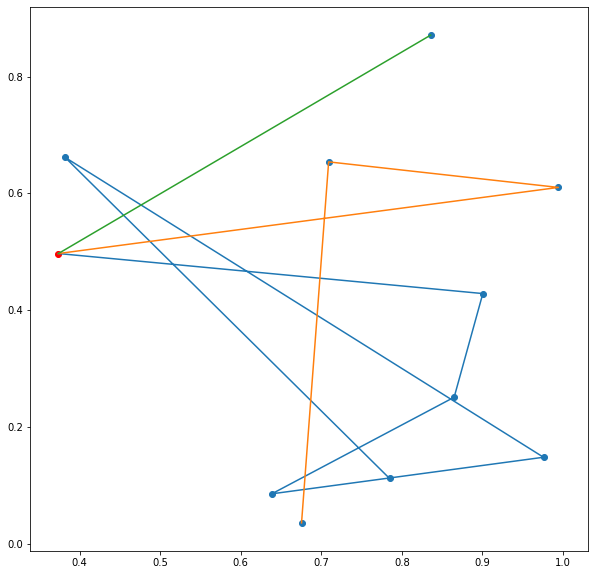

In [120]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(env.location[:, 1:-1, 0], env.location[:, 1:-1, 1])
plt.scatter(env.location[:, 0, 0], env.location[:, 0, 1], c='r')
for r in routes_model:
    print(env.tw[:, r, :])
    print(env.demand[:, r].sum())
    plt.plot(env.location[:, r, 0].squeeze(), env.location[:, r, 1].squeeze())

In [88]:
env.location[:, routes[0], 0], env.location[:, routes[0], 1]

(tensor([[0.3435, 0.7111]]), tensor([[0.0963, 0.2709]]))

tensor([[[  0.0000, 150.0000],
         [659.2280, 720.0000]]])
tensor([[[  0.0000, 150.0000],
         [333.7817, 453.7817],
         [327.5116, 447.5116],
         [539.3460, 659.3460],
         [679.7337, 720.0000]]])
tensor([[[  0.0000, 150.0000],
         [122.1164, 242.1164],
         [ 78.1076, 198.1076],
         [514.9916, 634.9916],
         [540.1365, 660.1365],
         [606.1751, 720.0000]]])


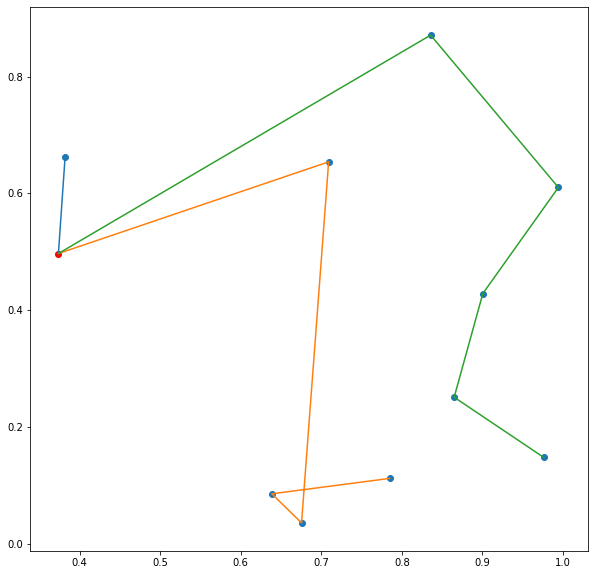

In [125]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(env.location[:, 1:-1, 0], env.location[:, 1:-1, 1])
plt.scatter(env.location[:, 0, 0], env.location[:, 0, 1], c='r')
for r in routes:
    print(env.tw[:, r, :])
    plt.plot(env.location[:, r, 0].squeeze(), env.location[:, r, 1].squeeze())

In [179]:
659/720 + 679.7337/720 + 606.1751/720

2.7012622222222222

In [ ]:
data = {}
data['time_matrix'] = env.distance.numpy()[1].squeeze()
data['num_vehicles'] = 10
data['time_windows'] = env.tw.numpy()[1].squeeze()
data['demands'] = env.demand.numpy()[1].squeeze()*env.capacity
data['vehicle_capacities'] = [env.capacity]*data['num_vehicles']
data['pickups_deliveries'] = env.pairs
compute_distance(data, eps=1e-2, time_limit=1)

## Обучение

In [ ]:
model = AttentionModel(active_num=1)
model = model.to('cuda')

In [ ]:
%%time
weights, _, _, _, _ = train(model, device="cuda", problem_size=100, num_vehicles=12,
                            batch_size=64, epochs=100, T=10, lr=1e-4, decay=0.001)

## Анимация

In [ ]:
opts = {'demand_type': {'distribution': 'uniform', 'max_demand':10},
        #'tw_type': {'distribution': 'uniform'},
        #"pickup_and_delivery":True
       }

n = 10
batch_size = 1
env = LogEnv(batch_size=batch_size, n=n, opts=opts)

features, distances, mask = env.reset()

demonstration(env, opts)

In [ ]:
actions_ext = np.array([2, 7, 3, 5, 1, 0, 6, 8, 9, 4])
action_animation(env, opts, actions_ext, '1-OtOPDTW.gif', 500)

In [ ]:
env = LogEnv(n=10, batch_size=1)
env.reset()
print('ready')

In [35]:
data['time_windows']

array([[  0.     , 150.     ],
       [469.74957, 589.7496 ],
       [170.58188, 290.58188],
       [475.91397, 595.91394],
       [569.9359 , 689.9359 ],
       [665.56506, 720.     ],
       [522.881  , 642.881  ],
       [294.45544, 414.45544],
       [130.69556, 250.69556],
       [646.6094 , 720.     ],
       [172.29248, 292.29248],
       [  0.     , 720.     ]], dtype=float32)

In [36]:
data['time_matrix']

array([[ 0.       , 16.319494 , 16.933798 , 16.316444 , 17.265072 ,
        15.835117 , 16.49948  , 15.738236 , 16.864378 , 16.901318 ,
        16.629303 ,  0.       ],
       [16.319494 ,  0.       , 18.253292 , 15.217478 , 17.70344  ,
        17.013098 , 17.818974 , 16.916218 , 18.183872 , 17.709583 ,
        17.948797 ,  0.       ],
       [16.933798 , 18.253292 ,  0.       , 18.250242 , 15.862671 ,
        17.237518 , 15.434319 , 17.140638 , 15.2955475, 15.543708 ,
        16.874886 ,  0.       ],
       [16.316444 , 15.217478 , 18.250242 ,  0.       , 17.70039  ,
        16.94771  , 17.815924 , 16.69874  , 18.180822 , 17.706533 ,
        17.945747 ,  0.       ],
       [17.265072 , 17.70344  , 15.862671 , 17.70039  ,  0.       ,
        18.10019  , 15.79687  , 18.00331  , 16.158218 , 15.363754 ,
        17.737556 ,  0.       ],
       [15.835117 , 17.013098 , 17.237518 , 16.94771  , 18.10019  ,
         0.       , 17.303318 , 15.559399 , 16.94197  , 17.736435 ,
        15.998037 ,

In [37]:
data['demands']

array([ 0.     , 22.     , 72.     , 95.00001, 32.     , 70.     ,
       91.     , 35.     , 57.     , 70.     , 80.     ,  0.     ],
      dtype=float32)

In [38]:
data['vehicle_capacities']

[700, 700, 700, 700, 700]

In [ ]:
env_plot(env)

In [ ]:
demonstration(env, model, device)

## Проверка модели CVRP, обученной на сервере

In [ ]:
file_name = 'JAMPR_TW1_20_Feb_13_05_57_10_2021'

In [ ]:
f = open('./models/' + file_name + '_best.pkl', 'rb')
weights = pickle.load(f)
f.close()

In [ ]:
file_name = 'JAMPR_TW1_20_Feb__6_11_23_38_2021'

In [ ]:
f = open('./models/' + file_name + '_loss.pkl', 'rb')
loss = pickle.load(f)
f.close()

In [ ]:
f = open('./models/' + file_name + '_reward.pkl', 'rb')
reward = pickle.load(f)
f.close()

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(reward)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.grid()
#fig.savefig('reward_20_twtsp.png')

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(loss)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean iteration loss', fontsize=20)
plt.grid()
#fig.savefig('loss_20_twtsp.png')

In [ ]:
file_name = 'JAMPR_TW1_20_Feb__8_20_09_51_2021'

In [ ]:
f = open('./models/' + file_name + '_loss.pkl', 'rb')
loss = pickle.load(f)
f.close()

In [ ]:
f = open('./models/' + file_name + '_reward.pkl', 'rb')
reward = pickle.load(f)
f.close()

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(reward)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.grid()
#fig.savefig('reward_20_twtsp.png')

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(loss)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean iteration loss', fontsize=20)
plt.grid()
#fig.savefig('loss_20_twtsp.png')

In [ ]:
file_name = 'JAMPR_TW1_20_Feb_10_14_16_41_2021'

In [ ]:
f = open('./models/' + file_name + '_loss.pkl', 'rb')
loss = pickle.load(f)
f.close()

In [ ]:
f = open('./models/' + file_name + '_reward.pkl', 'rb')
reward = pickle.load(f)
f.close()

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(reward)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.grid()
#fig.savefig('reward_20_twtsp.png')

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(loss)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean iteration loss', fontsize=20)
plt.grid()
#fig.savefig('loss_20_twtsp.png')

In [ ]:
file_name = 'JAMPR_TW1_20_Feb_12_17_23_34_2021'

In [ ]:
f = open('./models/' + file_name + '_loss.pkl', 'rb')
loss = pickle.load(f)
f.close()

In [ ]:
f = open('./models/' + file_name + '_reward.pkl', 'rb')
reward = pickle.load(f)
f.close()

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(reward)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.grid()
#fig.savefig('reward_20_twtsp.png')

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(loss)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean iteration loss', fontsize=20)
plt.grid()
#fig.savefig('loss_20_twtsp.png')

In [ ]:
file_name = 'JAMPR_TW1_20_Feb_12_18_22_54_2021'

In [ ]:
f = open('./models/' + file_name + '_loss.pkl', 'rb')
loss = pickle.load(f)
f.close()

In [ ]:
f = open('./models/' + file_name + '_reward.pkl', 'rb')
reward = pickle.load(f)
f.close()

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(reward)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.grid()
#fig.savefig('reward_20_twtsp.png')

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(loss)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean iteration loss', fontsize=20)
plt.grid()
#fig.savefig('loss_20_twtsp.png')

In [ ]:
file_name = 'JAMPR_TW1_20_Feb_13_05_57_10_2021'

In [ ]:
f = open('./models/' + file_name + '_loss.pkl', 'rb')
loss = pickle.load(f)
f.close()

In [ ]:
f = open('./models/' + file_name + '_reward.pkl', 'rb')
reward = pickle.load(f)
f.close()

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(reward)
plt.plot(np.ones(len(reward))*5000, )
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.grid()
plt.ylim([4000, 14000])
fig.savefig('reward_20_pdcvrptw.png')

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(loss)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean iteration loss', fontsize=20)
plt.grid()
#fig.savefig('loss_20_twtsp.png')

In [ ]:
file_name = 'JAMPR_TW1_20_Feb_15_04_32_07_2021'

In [ ]:
f = open('./models/' + file_name + '_loss.pkl', 'rb')
loss = pickle.load(f)
f.close()

In [ ]:
f = open('./models/' + file_name + '_reward.pkl', 'rb')
reward = pickle.load(f)
f.close()

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(reward)
plt.plot(np.ones(len(reward))*5000)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.grid()
#fig.savefig('reward_20_twtsp.png')

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(loss)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean iteration loss', fontsize=20)
plt.grid()
#fig.savefig('loss_20_twtsp.png')

In [ ]:
file_name = 'JAMPR_TW1_20_Feb_15_05_17_10_2021'

In [ ]:
f = open('./models/' + file_name + '_loss.pkl', 'rb')
loss = pickle.load(f)
f.close()

In [ ]:
f = open('./models/' + file_name + '_reward.pkl', 'rb')
reward = pickle.load(f)
f.close()

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(reward)
plt.plot(np.ones(len(reward))*5000, )
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.grid()
#fig.savefig('reward_20_twtsp.png')

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(loss)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean iteration loss', fontsize=20)
plt.grid()
#fig.savefig('loss_20_twtsp.png')

In [ ]:
model = AttentionModel(active_num=1).to("cuda")
model.load_state_dict(weights)

In [ ]:
model.eval()
print('r')

In [ ]:
%%time
compute_mean_metric(model, device="cuda", n=20, batch_size=1, T=10, sample=True)

In [ ]:
%%time
compute_mean_metric_with_or(model, device="cuda", n=20, batch_size=20, T=1, time_limit=0.5, eps=1e-2)

## JAMPR модифицированной на среде под реальную задачу

In [50]:
file_name = 'jampr_mod_real_100_Mar_14_15_52_29_2021'

In [4]:
f = open('./models/' + file_name + '_loss.pkl', 'rb')
loss = pickle.load(f)
f.close()

In [5]:
f = open('./models/' + file_name + '_reward.pkl', 'rb')
reward = pickle.load(f)
f.close()

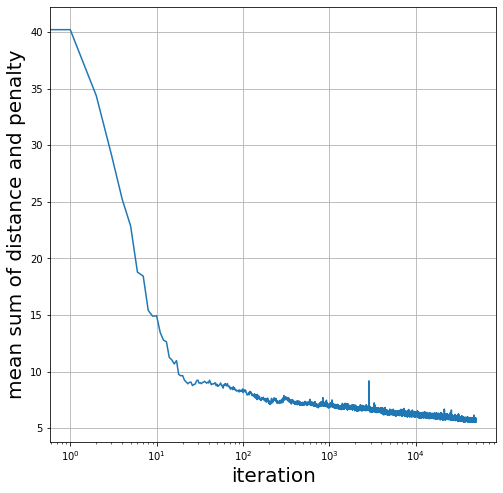

In [6]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(reward)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.grid()
#fig.savefig('reward_20_twtsp.png')

In [51]:
f = open('./models/' + file_name + '_best.pkl', 'rb')
weights = pickle.load(f)
f.close()

In [56]:
model = AttentionModel(active_num=1)
model = model.to('cuda')

In [57]:
model.load_state_dict(weights)
_ = model.eval()

In [133]:
%%time
compute_mean_metric_with_or(model, device="cuda", n=100, batch_size=1, T=10, sample=True, time_limit=10)

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
Wall time: 1min 45s


(5.565921878814697, 3984.1550540000003)

In [172]:
1 - 5.56/6.3

0.11746031746031749

## Реальные данные

In [67]:
with open('cvrp_tw_dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

In [68]:
env = LogEnv(n=100, batch_size=1, active_num=1, K=5)
env.reset(data=dataset[0])
'a'

'a'

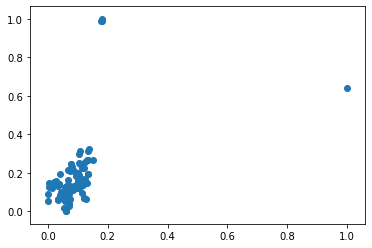

In [174]:
plt.scatter(dataset[0]['coords'][:, 0], dataset[0]['coords'][:, 1])

In [144]:
num_repeats = []
for i in range(100):
    num_repeats.append((dataset[i]['time_matrix'] == 15).sum())

In [113]:
%%time

model_metrics = []
or_metrics = []
routes = []
for data in dataset:
    m1, m2, r = compute_metric_on_data(model, data, device="cuda", n=100, time_limit=1, sample=False, eps=1e-5, K=12)
    model_metrics.append(m1)
    or_metrics.append(m2)
    routes.append(r)

tensor([0.])
tensor([11.])
tensor([11.])
tensor([0.])
tensor([17.])
tensor([1.])
tensor([1.])
tensor([0.])
tensor([0.])
tensor([1.])
tensor([1.])
tensor([0.])
tensor([5.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([1.])
tensor([0.])
tensor([6.])
tensor([1.])
tensor([0.])
tensor([0.])
tensor([4.])
tensor([10.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([4.])
tensor([3.])
tensor([0.])
tensor([10.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([1.])
tensor([5.])
tensor([4.])
tensor([0.])
tensor([2.])
tensor([0.])
tensor([2.])
tensor([0.])
tensor([1.])
tensor([5.])
tensor([0.])
tensor([0.])
tensor([1.])
tensor([11.])
tensor([10.])
tensor([10.])
tensor([0.])
tensor([3.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([5.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([13.])
tensor([0.])
tensor([9.])
tensor([0.])
tensor([1.])
tensor([0.])
tensor([0.])
tensor([22.])
tensor([0.])
tensor([5.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([2.])
tensor([0.])
tensor([0.])
te

In [148]:
model_metrics

[tensor([4.3231]),
 tensor([14.6803]),
 tensor([14.5977]),
 tensor([3.9496]),
 tensor([20.0549]),
 tensor([5.0428]),
 tensor([5.1788]),
 tensor([4.0068]),
 tensor([4.1761]),
 tensor([5.0810]),
 tensor([5.9474]),
 tensor([4.4616]),
 tensor([8.6070]),
 tensor([4.0457]),
 tensor([4.4785]),
 tensor([3.9830]),
 tensor([4.0475]),
 tensor([5.3363]),
 tensor([4.3016]),
 tensor([9.6959]),
 tensor([5.5763]),
 tensor([3.9045]),
 tensor([4.7651]),
 tensor([8.1163]),
 tensor([13.6922]),
 tensor([3.8361]),
 tensor([4.2242]),
 tensor([3.7687]),
 tensor([7.9089]),
 tensor([7.1141]),
 tensor([4.2334]),
 tensor([13.6014]),
 tensor([4.5042]),
 tensor([4.4502]),
 tensor([4.1690]),
 tensor([5.1883]),
 tensor([9.2445]),
 tensor([8.6288]),
 tensor([4.0449]),
 tensor([6.1144]),
 tensor([4.2999]),
 tensor([6.1404]),
 tensor([4.2446]),
 tensor([5.0781]),
 tensor([9.1339]),
 tensor([4.1811]),
 tensor([4.2908]),
 tensor([5.0712]),
 tensor([14.9417]),
 tensor([13.4820]),
 tensor([13.4367]),
 tensor([4.4114]),
 ten

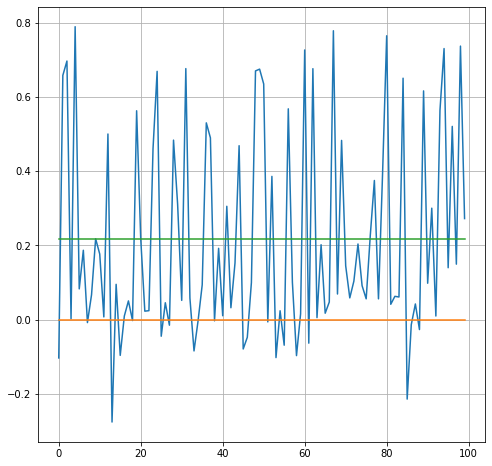

In [130]:
fig = plt.figure(figsize=(8, 8))
plt.plot(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics))
plt.plot(np.arange(100), [0]*100)
plt.plot(np.arange(100), [(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics)).mean()]*100)
plt.grid()

In [168]:
num_data = 67

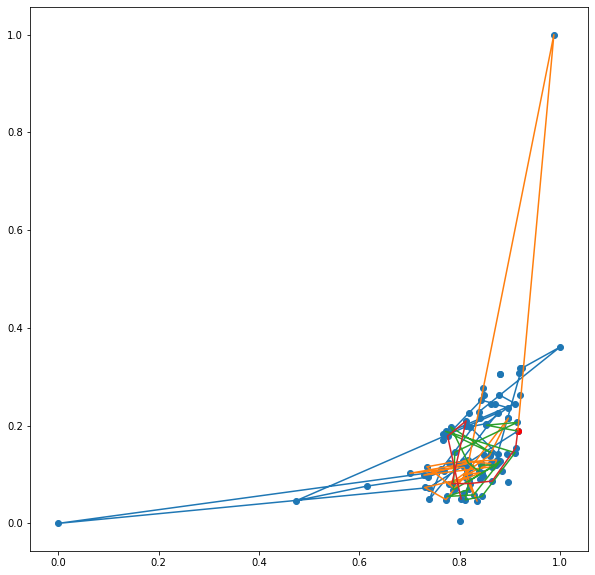

In [181]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(dataset[num_data]['coords'][:, 0], dataset[num_data]['coords'][:, 1])
plt.scatter(dataset[num_data]['coords'][0, 0], dataset[num_data]['coords'][0, 1], c='r')
for r in routes[num_data][0].squeeze():
    plt.plot(dataset[num_data]['coords'][r, 0], dataset[num_data]['coords'][r, 1])